In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf
from util.plotting import *
from util.util_data import *
from datetime import date, datetime, time, timedelta
import json
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import warnings
from scipy.stats import gmean
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'libertine'
plt.rcParams['font.weight'] = 'bold'


## figs. day-of-week(1x3), and hour-of-day(1x3) incident count distribution.

### Load incident data

In [22]:
# load incident data
path = f'data/clean/incident/2024-08-31/incident_stages.csv'
df = pd.read_csv(path)

# status_lst = ['investigating', 'identified', 'monitoring', 'resolved', 'postmortem', 'start']
# for status in status_lst:
#     df[f'{status}_timestamp'] = pd.to_datetime(df[f'{status}_timestamp'])

status_lst = ['investigating', 'identified', 'monitoring', 'resolved', 'postmortem', 'start']
for status in status_lst:
    df[f'{status}_timestamp'] = pd.to_datetime(df[f'{status}_timestamp'], errors='coerce')
    # convert to PDT time
    df[f'{status}_timestamp'] = df[f'{status}_timestamp'].dt.tz_convert('US/Pacific')
    # remove timezone information
    df[f'{status}_timestamp'] = pd.to_datetime(df[f'{status}_timestamp']).dt.tz_localize(None)

# filter out df corner cases
count_lst = 5 * [0]
corner_cases = pd.DataFrame()

for index, record in df.iterrows():
    if record['investigating_timestamp'] > record['identified_timestamp']:
        count_lst[0] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
    if record['identified_timestamp'] > record['monitoring_timestamp']:
        count_lst[1] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
    if record['monitoring_timestamp'] > record['resolved_timestamp']:
        count_lst[2] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
    if record['resolved_timestamp'] > record['postmortem_timestamp']:
        count_lst[3] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
print(count_lst)

# transposing corner cases
corner_cases = corner_cases.T
# display(corner_cases)

# filter out df corner cases
df = df.drop(corner_cases.index)
df = df.reset_index(drop=True)

df = df.rename(columns={'API': 'API-OpenAI', 'ChatGPT': 'ChatGPT', 'Labs': 'DALL·E', 'Playground': 'Playground', 'api.anthropic.com': 'API-Anthropic', 'claude.ai': 'Claude', 'console.anthropic.com': 'Console', 'Character.AI': 'Character.AI'})
service_lst = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']

dfs = {}
for service in service_lst:
    dfs[service] = df[df[service] == 1]
    dfs[service].reset_index(drop=True, inplace=True)

df.head()

[2, 3, 0, 0, 0]


,incident_id,Incident_Title,incident_impact_level,Incident_color,provider,Playground,API-OpenAI,DALL·E,ChatGPT,API-Anthropic,Claude,Console,Character.AI,investigating_flag,investigating_timestamp,investigating_description,identified_flag,identified_timestamp,identified_description,monitoring_flag,monitoring_timestamp,monitoring_description,resolved_flag,resolved_timestamp,resolved_description,postmortem_flag,postmortem_timestamp,postmortem_description,start_timestamp,close_timestamp,time_span,over_one_day
0,qv89mzdjvtrs,Elevated Errors,1,#f1c40f,anthropic,0,0,0,0,1,1,1,0,1,2024-02-26 09:09:00,We're experiencing an elevated level of API er...,1,2024-02-26 09:37:00,The issue has been identified and a fix is bei...,1,2024-02-26 09:41:00,A fix has been implemented and we are monitori...,1,2024-02-26 10:21:00,This incident has been resolved.,0,NaT,NaN,2024-02-26 09:09:00,2024-02-26 18:21:00+00:00,0 days 01:12:00,False
1,tmsczhzhjd63,Elevated error rate on claude.ai,0,#333333,anthropic,0,0,0,0,0,0,0,0,0,NaT,NaN,0,NaT,NaN,0,NaT,NaN,1,2024-02-16 12:35:00,We experienced an elevated level of errors on ...,0,NaT,NaN,2024-02-16 12:35:00,2024-02-16 20:35:00+00:00,0 days 00:00:00,False
2,t6v85cs8j6jb,"Elevated error rate on Claude-2.0, Claude-2.1",0,#333333,anthropic,0,0,0,0,1,1,1,0,1,2024-02-12 19:59:00,We are currently investigating this issue.,1,2024-02-12 20:21:00,The issue has been identified and a fix is bei...,1,2024-02-12 20:30:00,A fix has been implemented and we are monitori...,1,2024-02-12 20:36:00,This incident has been resolved.,0,NaT,NaN,2024-02-12 19:59:00,2024-02-13 04:36:00+00:00,0 days 00:37:00,False
3,x5f4s8nvkyqq,"Elevated error rate on Claude-2.0, Claude-2.1",0,#333333,anthropic,0,0,0,0,1,1,1,0,1,2024-02-12 16:21:00,We are currently investigating this issue.,1,2024-02-12 16:50:00,The issue has been identified and a fix is bei...,1,2024-02-12 16:59:00,A fix has been implemented and we are monitori...,1,2024-02-12 17:26:00,This incident has been resolved.,0,NaT,NaN,2024-02-12 16:21:00,2024-02-13 01:26:00+00:00,0 days 01:05:00,False
4,gr7nb0dwyydw,elevated error rates on claude-instant-1.2,0,#333333,anthropic,0,0,0,0,1,1,1,0,1,2024-02-05 15:07:00,We are currently investigating this issue.,0,NaT,NaN,1,2024-02-05 15:58:00,A fix has been implemented and we are monitori...,1,2024-02-05 17:55:00,This incident has been resolved.,0,NaT,NaN,2024-02-05 15:07:00,2024-02-06 01:55:00+00:00,0 days 02:48:00,False


In [3]:
df.columns

Index(['incident_id', 'Incident_Title', 'incident_impact_level',
       'Incident_color', 'provider', 'Playground', 'API-OpenAI', 'DALL·E',
       'ChatGPT', 'API-Anthropic', 'Claude', 'Console', 'Character.AI',
       'investigating_flag', 'investigating_timestamp',
       'investigating_description', 'identified_flag', 'identified_timestamp',
       'identified_description', 'monitoring_flag', 'monitoring_timestamp',
       'monitoring_description', 'resolved_flag', 'resolved_timestamp',
       'resolved_description', 'postmortem_flag', 'postmortem_timestamp',
       'postmortem_description', 'start_timestamp', 'close_timestamp',
       'time_span', 'over_one_day'],
      dtype='object')

### temporal distribution of incidents

In [4]:
## data preparation
openai_services = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground']
anthropic_services = ['API-Anthropic', 'Claude', 'Console']
character_ai_services = ['Character.AI']

openai_day_of_week_dfs = {}
anthropic_day_of_week_dfs = {}
character_ai_day_of_week_dfs = {}
for provider, services in zip(['OpenAI', 'Anthropic', 'Character.AI'], [openai_services, anthropic_services, character_ai_services]):
    for service in services:
        df = dfs[service]
        df['Day'] = df['start_timestamp'].dt.day_name()
        df['Day'] = pd.Categorical(df['Day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
        day_of_week = df.groupby('Day')['resolved_flag'].sum()
        if provider == 'OpenAI':
            openai_day_of_week_dfs[service] = day_of_week
        elif provider == 'Anthropic':
            anthropic_day_of_week_dfs[service] = day_of_week
        elif provider == 'Character.AI':
            character_ai_day_of_week_dfs[service] = day_of_week

openai_day_of_week_dfs['API-OpenAI']

Day
Monday       30
Tuesday      40
Wednesday    57
Thursday     48
Friday       38
Saturday      8
Sunday        6
Name: resolved_flag, dtype: int64

Incident Count by Day of Week


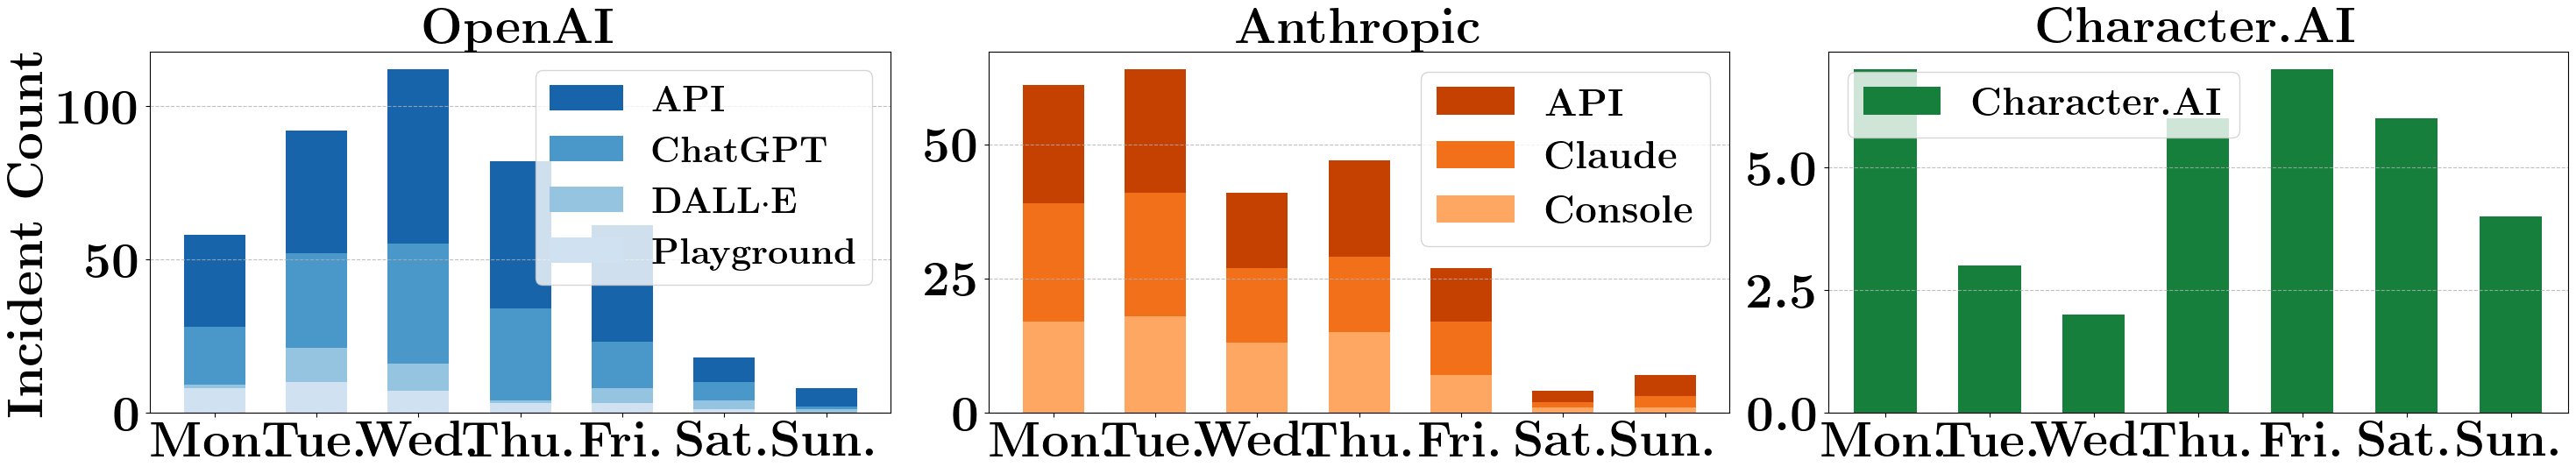

In [23]:
# incidetn count by day of week, 3 subplots in one row for each provider, aggregated by service
print('Incident Count by Day of Week')

set_half_column_figure_font(height_multiplier=1.0)
fig, axs = plt.subplots(1, 3, figsize=(30, 6))
fig.subplots_adjust(wspace=0.0)

# OpenAI
ax = axs[0]
colors = sns.color_palette('Blues', 4)
# colors = sns.color_palette('Set2', 4)
colors = colors[::-1]
# hatches = ['o', 'x', '.', '+']
hatches = ['', '', '', '']
for service in openai_services:
    playground = ax.bar(openai_day_of_week_dfs[service].index, openai_day_of_week_dfs[service], color=colors[3], width=0.6, hatch=hatches[3])
    dalle = ax.bar(openai_day_of_week_dfs[service].index, openai_day_of_week_dfs[service], color=colors[2], width=0.6, hatch=hatches[2], bottom=openai_day_of_week_dfs['Playground'])
    chatgpt = ax.bar(openai_day_of_week_dfs[service].index, openai_day_of_week_dfs[service], color=colors[1], width=0.6, hatch=hatches[1], bottom=openai_day_of_week_dfs['DALL·E'] + openai_day_of_week_dfs['Playground'])
    api = ax.bar(openai_day_of_week_dfs[service].index, openai_day_of_week_dfs[service], color=colors[0], width=0.6, hatch=hatches[0], bottom=openai_day_of_week_dfs['ChatGPT'] + openai_day_of_week_dfs['DALL·E'] + openai_day_of_week_dfs['Playground'])

    ax.set_title(r'\textbf{OpenAI}', fontsize=41)
    ax.set_xlabel('')
    ax.legend([api, chatgpt, dalle, playground], [r'\textbf{API}', r'\textbf{ChatGPT}', r'\textbf{DALL·E}', r'\textbf{Playground}'], loc='upper right', fontsize=30)
    ax.set_ylabel(r'\textbf{Incident Count}', fontsize=41)
    labels = [r"\textbf{Mon.}", r"\textbf{Tue.}", r"\textbf{Wed.}", r"\textbf{Thu.}", r"\textbf{Fri.}", r"\textbf{Sat.}", r"\textbf{Sun.}"]
    ax.set_xticklabels(labels, rotation=0, fontsize=41)
    ax.grid(axis='y', linestyle='--', alpha=0.8)
    ax.xaxis.set_tick_params(labelsize=41)
    ax.yaxis.set_tick_params(labelsize=41)

# Anthropic
ax = axs[1]
colors = sns.color_palette('Oranges', 4)
colors = colors[::-1]
# hatches = ['o', 'x', '.', '+']
hatches = ['', '', '', '']
for service in anthropic_services:
    console = ax.bar(anthropic_day_of_week_dfs[service].index, anthropic_day_of_week_dfs[service], width=0.6, color=colors[2], hatch=hatches[2])
    claude = ax.bar(anthropic_day_of_week_dfs[service].index, anthropic_day_of_week_dfs[service], width=0.6, color=colors[1], hatch=hatches[1], bottom=anthropic_day_of_week_dfs['Console'])
    api_anthropic = ax.bar(anthropic_day_of_week_dfs[service].index, anthropic_day_of_week_dfs[service], width=0.6, color=colors[0], hatch=hatches[0], bottom=anthropic_day_of_week_dfs['Claude'] + anthropic_day_of_week_dfs['Console'])
    ax.set_title(r'\textbf{Anthropic}', fontsize=41)
    ax.set_xlabel('')
    ax.legend([api_anthropic, claude, console], [r'\textbf{API}', r'\textbf{Claude}', r'\textbf{Console}'], loc='upper right', fontsize=32)
    # ax.set_ylabel(r'\textbf{Outage Count}')
    labels = [r"\textbf{Mon.}", r"\textbf{Tue.}", r"\textbf{Wed.}", r"\textbf{Thu.}", r"\textbf{Fri.}", r"\textbf{Sat.}", r"\textbf{Sun.}"]
    ax.set_xticklabels(labels, rotation=0, fontsize=41)
    ax.grid(axis='y', linestyle='--', alpha=0.8)
    ax.xaxis.set_tick_params(labelsize=41)
    ax.yaxis.set_tick_params(labelsize=41)

# Character.AI
ax = axs[2]
colors = sns.color_palette('Greens', 4)
# hatches = ['o', 'x', '.', '+']
hatches = ['', '', '', '']
for service in character_ai_services:
    character_ai_day_of_week_dfs[service].plot(kind='bar', ax=ax, color=colors[3], hatch=hatches[0], width=0.6)
    ax.set_title(r'\textbf{Character.AI}', fontsize=41)
    ax.set_xlabel('')
    ax.legend([r'\textbf{Character.AI}'], loc='upper left', fontsize=32)
    # ax.set_ylabel(r'\textbf{Outage Count}')
    labels = [r"\textbf{Mon.}", r"\textbf{Tue.}", r"\textbf{Wed.}", r"\textbf{Thu.}", r"\textbf{Fri.}", r"\textbf{Sat.}", r"\textbf{Sun.}"]
    ax.set_xticklabels(labels, rotation=0, fontsize=41)
    ax.grid(axis='y', linestyle='--', alpha=0.8)
    ax.xaxis.set_tick_params(labelsize=41)
    ax.yaxis.set_tick_params(labelsize=41)

plt.subplots_adjust(wspace=0.0)
plt.tight_layout()
plt.savefig('plot/sec5-temporal_analysis/incident_count_day_of_week_by_provider.pdf', bbox_inches='tight')
plt.savefig('plot/sec5-temporal_analysis/incident_count_day_of_week_by_provider.png', bbox_inches='tight')
plt.show()

In [5]:
# data preparation
openai_services = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground']
anthropic_services = ['API-Anthropic', 'Claude', 'Console']
character_ai_services = ['Character.AI']

openai_hour_of_day_dfs = {}
anthropic_hour_of_day_dfs = {}
character_ai_hour_of_day_dfs = {}
for provider, services in zip(['OpenAI', 'Anthropic', 'Character.AI'], [openai_services, anthropic_services, character_ai_services]):
    for service in services:
        df = dfs[service]
        # df['Day'] = df['start_timestamp'].dt.day_name()
        # df['Day'] = pd.Categorical(df['Day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
        # day_of_week = df.groupby('Day')['resolved_flag'].sum()
        df['Hour'] = df['start_timestamp'].dt.hour
        df['Hour'] = pd.Categorical(df['Hour'], categories=range(24), ordered=True)
        hour_of_day = df.groupby('Hour')['resolved_flag'].sum()
        if provider == 'OpenAI':
            openai_hour_of_day_dfs[service] = hour_of_day
        elif provider == 'Anthropic':
            anthropic_hour_of_day_dfs[service] = hour_of_day
        elif provider == 'Character.AI':
            character_ai_hour_of_day_dfs[service] = hour_of_day

# openai_hour_of_day_dfs['API-OpenAI']


Incident Count by Hour of Day


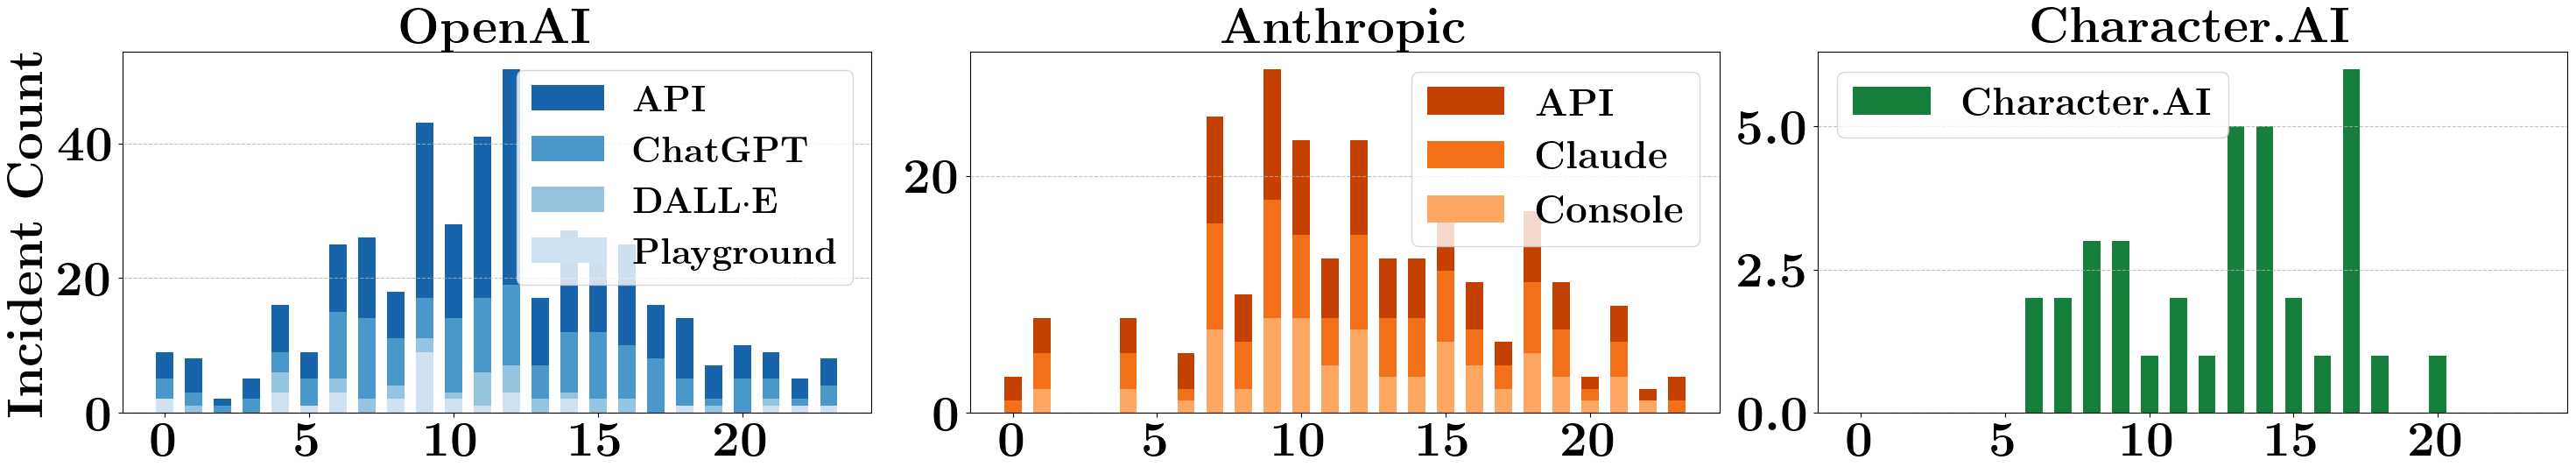

In [20]:
# incidetn count by hour of day, 3 subplots in one row for each provider, aggregated by service
print('Incident Count by Hour of Day')
set_half_column_figure_font(height_multiplier=1.0)
fig, axs = plt.subplots(1, 3, figsize=(30, 6))
fig.subplots_adjust(wspace=0.0)

# OpenAI
ax = axs[0]
colors = sns.color_palette('Blues', 4)
# colors = sns.color_palette('Set2', 4)
colors = colors[::-1]
# hatches = ['o', 'x', '.', '+']
hatches = ['', '', '', '']
for service in openai_services:
    playground = ax.bar(openai_hour_of_day_dfs[service].index, openai_hour_of_day_dfs[service], color=colors[3], width=0.6, hatch=hatches[3])
    dalle = ax.bar(openai_hour_of_day_dfs[service].index, openai_hour_of_day_dfs[service], color=colors[2], width=0.6, hatch=hatches[2], bottom=openai_hour_of_day_dfs['Playground'])
    chatgpt = ax.bar(openai_hour_of_day_dfs[service].index, openai_hour_of_day_dfs[service], color=colors[1], width=0.6, hatch=hatches[1], bottom=openai_hour_of_day_dfs['DALL·E'] + openai_hour_of_day_dfs['Playground'])
    api = ax.bar(openai_hour_of_day_dfs[service].index, openai_hour_of_day_dfs[service], color=colors[0], width=0.6, hatch=hatches[0], bottom=openai_hour_of_day_dfs['ChatGPT'] + openai_hour_of_day_dfs['DALL·E'] + openai_hour_of_day_dfs['Playground'])

    ax.set_title(r'\textbf{OpenAI}', fontsize=41)
    ax.set_xlabel('')
    ax.legend([api, chatgpt, dalle, playground], [r'\textbf{API}', r'\textbf{ChatGPT}', r'\textbf{DALL·E}', r'\textbf{Playground}'], loc='upper right', fontsize=30)
    ax.set_ylabel(r'\textbf{Incident Count}', fontsize=41)
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.grid(axis='y', linestyle='--', alpha=0.8)
    ax.xaxis.set_tick_params(labelsize=41, rotation=0)
    ax.yaxis.set_tick_params(labelsize=41)

# Anthropic
ax = axs[1]
colors = sns.color_palette('Oranges', 4)
colors = colors[::-1]
# hatches = ['o', 'x', '.', '+']
hatches = ['', '', '', '']
for service in anthropic_services:
    console = ax.bar(anthropic_hour_of_day_dfs[service].index, anthropic_hour_of_day_dfs[service], width=0.6, color=colors[2], hatch=hatches[2])
    claude = ax.bar(anthropic_hour_of_day_dfs[service].index, anthropic_hour_of_day_dfs[service], width=0.6, color=colors[1], hatch=hatches[1], bottom=anthropic_hour_of_day_dfs['Console'])
    api_anthropic = ax.bar(anthropic_hour_of_day_dfs[service].index, anthropic_hour_of_day_dfs[service], width=0.6, color=colors[0], hatch=hatches[0], bottom=anthropic_hour_of_day_dfs['Claude'] + anthropic_hour_of_day_dfs['Console'])
    ax.set_title(r'\textbf{Anthropic}', fontsize=41)
    ax.set_xlabel('')
    ax.legend([api_anthropic, claude, console], [r'\textbf{API}', r'\textbf{Claude}', r'\textbf{Console}'], loc='upper right', fontsize=32)
    # ax.set_ylabel(r'\textbf{Outage Count}')
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.grid(axis='y', linestyle='--', alpha=0.8)
    ax.xaxis.set_tick_params(labelsize=41)
    ax.yaxis.set_tick_params(labelsize=41)

# Character.AI
ax = axs[2]
colors = sns.color_palette('Greens', 4)
# hatches = ['o', 'x', '.', '+']
hatches = ['', '', '', '']
for service in character_ai_services:
    # character_ai = character_ai_hour_of_day_dfs[service].plot(kind='bar', ax=ax, color=colors[3], hatch=hatches[0], width=0.6)
    character_ai = ax.bar(character_ai_hour_of_day_dfs[service].index, character_ai_hour_of_day_dfs[service], color=colors[3], width=0.6, hatch=hatches[0])
    ax.set_title(r'\textbf{Character.AI}', fontsize=41)
    ax.set_xlabel('')
    ax.legend([r'\textbf{Character.AI}'], loc='upper left', fontsize=32)
    # ax.set_ylabel(r'\textbf{Outage Count}')
    # set x-axis labels, 0, 5, 10, 15, 20
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.grid(axis='y', linestyle='--', alpha=0.8)
    ax.xaxis.set_tick_params(labelsize=41, rotation=0)
    ax.yaxis.set_tick_params(labelsize=41)

plt.subplots_adjust(wspace=0.0)
plt.tight_layout()
plt.savefig('plot/sec5-temporal_analysis/incident_count_hour_of_day_by_provider.pdf', bbox_inches='tight')
plt.savefig('plot/sec5-temporal_analysis/incident_count_hour_of_day_by_provider.png', bbox_inches='tight')
plt.show()

## Auto-correlation of incidents: by month, week, day

### Load incident data

In [2]:
# load incident data
path = f'data/clean/incident/2024-08-31/incident_stages.csv'
df = pd.read_csv(path)

# status_lst = ['investigating', 'identified', 'monitoring', 'resolved', 'postmortem', 'start']
# for status in status_lst:
#     df[f'{status}_timestamp'] = pd.to_datetime(df[f'{status}_timestamp'])

status_lst = ['investigating', 'identified', 'monitoring', 'resolved', 'postmortem', 'start']
for status in status_lst:
    df[f'{status}_timestamp'] = pd.to_datetime(df[f'{status}_timestamp'], errors='coerce')
    # convert to PDT time
    df[f'{status}_timestamp'] = df[f'{status}_timestamp'].dt.tz_convert('US/Pacific')
    # remove timezone information
    df[f'{status}_timestamp'] = pd.to_datetime(df[f'{status}_timestamp']).dt.tz_localize(None)

# filter out df corner cases
count_lst = 5 * [0]
corner_cases = pd.DataFrame()

for index, record in df.iterrows():
    if record['investigating_timestamp'] > record['identified_timestamp']:
        count_lst[0] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
    if record['identified_timestamp'] > record['monitoring_timestamp']:
        count_lst[1] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
    if record['monitoring_timestamp'] > record['resolved_timestamp']:
        count_lst[2] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
    if record['resolved_timestamp'] > record['postmortem_timestamp']:
        count_lst[3] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
print(count_lst)

# transposing corner cases
corner_cases = corner_cases.T
# display(corner_cases)

# filter out df corner cases
df = df.drop(corner_cases.index)
df = df.reset_index(drop=True)

df = df.rename(columns={'API': 'API-OpenAI', 'ChatGPT': 'ChatGPT', 'Labs': 'DALL·E', 'Playground': 'Playground', 'api.anthropic.com': 'API-Anthropic', 'claude.ai': 'Claude', 'console.anthropic.com': 'Console', 'Character.AI': 'Character.AI'})
service_lst = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']

dfs = {}
for service in service_lst:
    dfs[service] = df[df[service] == 1]
    dfs[service].reset_index(drop=True, inplace=True)

provider_lst = ['openai', 'anthropic', 'character']
dfs_provider = {}
for provider in provider_lst:
    for service in service_lst:
        if provider in dfs[service]['provider'].unique():
            dfs_provider[provider] = dfs_provider.get(provider, pd.DataFrame())
            dfs_provider[provider] = pd.concat([dfs_provider[provider], dfs[service][dfs[service]['provider'] == provider]], axis=0)

display(dfs_provider['openai'].head())

[2, 3, 0, 0, 0]


,incident_id,Incident_Title,incident_impact_level,Incident_color,provider,Playground,API-OpenAI,DALL·E,ChatGPT,API-Anthropic,Claude,Console,Character.AI,investigating_flag,investigating_timestamp,investigating_description,identified_flag,identified_timestamp,identified_description,monitoring_flag,monitoring_timestamp,monitoring_description,resolved_flag,resolved_timestamp,resolved_description,postmortem_flag,postmortem_timestamp,postmortem_description,start_timestamp,close_timestamp,time_span,over_one_day
0,zm9ssldbs7ds,Increased queue wait times for GPT-3.5-Turbo f...,1,#f4ac36,openai,0,1,0,0,0,0,0,0,0,NaT,NaN,1,2024-02-29 12:41:00,We are seeing a spike in demand for 3.5 turbo ...,1,2024-02-29 18:16:00,The queue length is settling and wait times fo...,1,2024-02-29 20:13:00,This incident has been resolved.,0,NaT,NaN,2024-02-29 12:41:00,2024-03-01 04:13:00+00:00,0 days 07:32:00,False
1,62wkltqhbrmk,Elevated error rate impacting API services (in...,2,#e86c09,openai,0,1,0,0,0,0,0,0,1,2024-02-14 07:06:00,We are currently investigating this issue.,0,NaT,NaN,1,2024-02-14 10:38:00,A fix has been implemented and we are monitori...,1,2024-02-14 12:40:00,This incident has been resolved.,0,NaT,NaN,2024-02-14 07:06:00,2024-02-14 20:40:00+00:00,0 days 05:34:00,False
2,70p519qgngrw,Elevated errors on GPT-4V for ChatGPT and API,2,#e86c09,openai,0,1,0,1,0,0,0,0,1,2024-02-13 07:03:00,We are currently investigating this issue.,1,2024-02-13 07:36:00,The issue has been identified and a fix is bei...,1,2024-02-14 10:39:00,A fix has been implemented and we are monitori...,1,2024-02-14 12:40:00,This incident has been resolved.,0,NaT,NaN,2024-02-13 07:03:00,2024-02-14 20:40:00+00:00,1 days 05:37:00,True
3,mswp9vt22gm2,Elevated errors across multiple API endpoints ...,2,#e86c09,openai,0,1,0,1,0,0,0,0,1,2024-02-13 12:11:00,We are currently investigating this issue.,1,2024-02-13 12:38:00,We have identified this issue and a fix is bei...,1,2024-02-13 13:46:00,"A fix has been implemented, and we are monitor...",1,2024-02-13 15:38:00,This incident has been resolved.,0,NaT,NaN,2024-02-13 12:11:00,2024-02-13 23:38:00+00:00,0 days 03:27:00,False
4,shqybftjc7mc,Elevated errors on GPT-4V for ChatGPT and API,1,#f4ac36,openai,0,1,0,1,0,0,0,0,0,NaT,NaN,1,2024-02-12 09:19:00,We are currently investigating this issue.,1,2024-02-12 10:19:00,A fix has been implemented and we are monitori...,1,2024-02-12 10:39:00,This incident has been resolved.,0,NaT,NaN,2024-02-12 09:19:00,2024-02-12 18:39:00+00:00,0 days 01:20:00,False


### OpenAI autocorelation

In [94]:
df = dfs_provider['openai']

df['incident_start_time'] = df[['investigating_timestamp', 'identified_timestamp', 'monitoring_timestamp', 'resolved_timestamp']].min(axis=1)
df = df[['resolved_flag', 'incident_start_time']]

# add column 'year', 'month', 'week', 'day', 'hour'
df['year'] = df['incident_start_time'].dt.year
df['month_of_year'] = df['incident_start_time'].dt.month
df['week_of_year'] = df['incident_start_time'].dt.isocalendar().week
df['day_of_year'] = df['incident_start_time'].dt.dayofyear
df['hour_of_day'] = df['incident_start_time'].dt.hour

# add column 'year_num', 'month_num', 'week_num', 'day_num', 'hour_num'
df['year_num'] = df['year'] - df['year'].min()
df['month_num'] = df['year_num'] * 12 + df['month_of_year']
df['week_num'] = df['year_num'] * 52 + df['week_of_year']
df['day_num'] = df['year_num'] * 365 + df['day_of_year']
df['hour_num'] = df['day_num'] * 24 + df['hour_of_day']

# select and group columns for auto-correlation
df_month = df[['month_num', 'resolved_flag']]
group_by_month = df_month.groupby('month_num')['resolved_flag'].sum()
df_month = pd.DataFrame({'month_num': range(max(group_by_month.index)+1), 'resolved_flag': 0})
df_month = df_month.merge(group_by_month, how='left', on='month_num').fillna(0)
df_month = df_month['resolved_flag_y']

df_week = df[['week_num', 'resolved_flag']]
group_by_week = df_week.groupby('week_num')['resolved_flag'].sum()
df_week = pd.DataFrame({'week_num': range(max(group_by_week.index)+1), 'resolved_flag': 0})
df_week = df_week.merge(group_by_week, how='left', on='week_num').fillna(0)
df_week = df_week['resolved_flag_y']

df_day = df[['day_num', 'resolved_flag']]
group_by_day = df_day.groupby('day_num')['resolved_flag'].sum()
df_day = pd.DataFrame({'day_num': range(max(group_by_day.index)+1), 'resolved_flag': 0})
df_day = df_day.merge(group_by_day, how='left', on='day_num').fillna(0)
df_day = df_day['resolved_flag_y']

df_hour = df[['hour_num', 'resolved_flag']]
group_by_hour = df_hour.groupby('hour_num')['resolved_flag'].sum()
df_hour = pd.DataFrame({'hour_num': range(max(group_by_hour.index)+1), 'resolved_flag': 0})
df_hour = df_hour.merge(group_by_hour, how='left', on='hour_num').fillna(0)
df_hour = df_hour['resolved_flag_y']

print(len(df_month), len(df_week), len(df_day), len(df_hour))

45 192 1337 32076


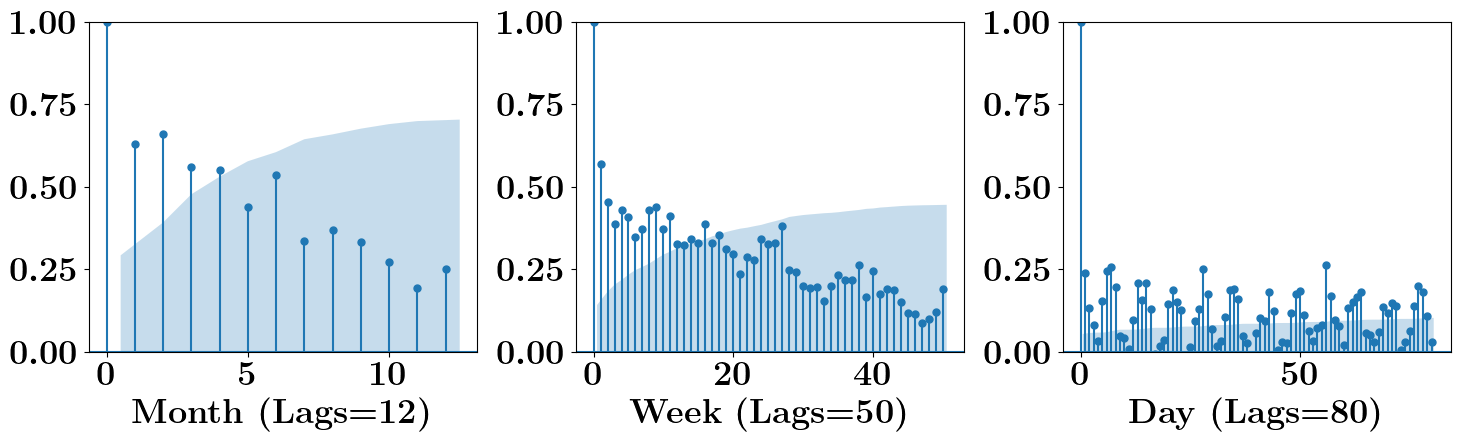

In [95]:
# plotting auto-correlation for df_month, df_week, df_day
set_half_column_figure_font(height_multiplier=1.0)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.subplots_adjust(wspace=0.0)

# month
ax = axs[0]
plot_acf(df_month, lags=12, ax=ax)
ax.set_title('')
ax.set_xlabel(r'\textbf{Month (Lags=12)}', fontsize=24.9)
ax.xaxis.set_tick_params(labelsize=24.9)
ax.yaxis.set_tick_params(labelsize=24.9)
ax.set_ylim(bottom=0)

# week
ax = axs[1]
plot_acf(df_week, lags=50, ax=ax)
ax.set_title('')
ax.set_xlabel(r'\textbf{Week (Lags=50)}', fontsize=24.9)
ax.xaxis.set_tick_params(labelsize=24.9)
ax.yaxis.set_tick_params(labelsize=24.9)
ax.set_ylim(bottom=0)

# day
ax = axs[2]
plot_acf(df_day, lags=80, ax=ax)
ax.set_title('')
ax.set_xlabel(r'\textbf{Day (Lags=80)}', fontsize=24.9)
ax.xaxis.set_tick_params(labelsize=24.9)
ax.yaxis.set_tick_params(labelsize=24.9)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('plot/sec5-temporal_analysis/auto_correlation_openai.pdf')
plt.savefig('plot/sec5-temporal_analysis/auto_correlation_openai.png')

plt.show()


### Anthropic auto-correlation

In [96]:
df = dfs_provider['anthropic']

df['incident_start_time'] = df[['investigating_timestamp', 'identified_timestamp', 'monitoring_timestamp', 'resolved_timestamp']].min(axis=1)
df = df[['resolved_flag', 'incident_start_time']]

# add column 'year', 'month', 'week', 'day', 'hour'
df['year'] = df['incident_start_time'].dt.year
df['month_of_year'] = df['incident_start_time'].dt.month
df['week_of_year'] = df['incident_start_time'].dt.isocalendar().week
df['day_of_year'] = df['incident_start_time'].dt.dayofyear
df['hour_of_day'] = df['incident_start_time'].dt.hour

# add column 'year_num', 'month_num', 'week_num', 'day_num', 'hour_num'
df['year_num'] = df['year'] - df['year'].min()
df['month_num'] = df['year_num'] * 12 + df['month_of_year']
df['week_num'] = df['year_num'] * 52 + df['week_of_year']
df['day_num'] = df['year_num'] * 365 + df['day_of_year']
df['hour_num'] = df['day_num'] * 24 + df['hour_of_day']

# select and group columns for auto-correlation
df_month = df[['month_num', 'resolved_flag']]
group_by_month = df_month.groupby('month_num')['resolved_flag'].sum()
df_month = pd.DataFrame({'month_num': range(max(group_by_month.index)+1), 'resolved_flag': 0})
df_month = df_month.merge(group_by_month, how='left', on='month_num').fillna(0)
df_month = df_month['resolved_flag_y']

df_week = df[['week_num', 'resolved_flag']]
group_by_week = df_week.groupby('week_num')['resolved_flag'].sum()
df_week = pd.DataFrame({'week_num': range(max(group_by_week.index)+1), 'resolved_flag': 0})
df_week = df_week.merge(group_by_week, how='left', on='week_num').fillna(0)
df_week = df_week['resolved_flag_y']

df_day = df[['day_num', 'resolved_flag']]
group_by_day = df_day.groupby('day_num')['resolved_flag'].sum()
df_day = pd.DataFrame({'day_num': range(max(group_by_day.index)+1), 'resolved_flag': 0})
df_day = df_day.merge(group_by_day, how='left', on='day_num').fillna(0)
df_day = df_day['resolved_flag_y']

df_hour = df[['hour_num', 'resolved_flag']]
group_by_hour = df_hour.groupby('hour_num')['resolved_flag'].sum()
df_hour = pd.DataFrame({'hour_num': range(max(group_by_hour.index)+1), 'resolved_flag': 0})
df_hour = df_hour.merge(group_by_hour, how='left', on='hour_num').fillna(0)
df_hour = df_hour['resolved_flag_y']

print(len(df_month), len(df_week), len(df_day), len(df_hour))

21 88 606 14539


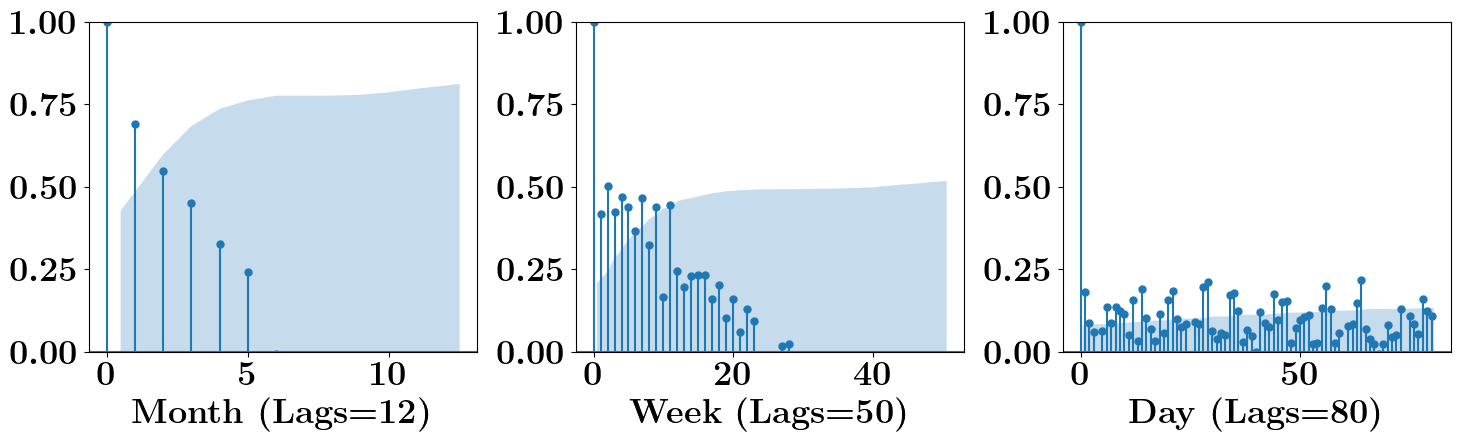

In [97]:
# plotting auto-correlation for df_month, df_week, df_day
set_half_column_figure_font(height_multiplier=1.0)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.subplots_adjust(wspace=0.0)

# month
ax = axs[0]
plot_acf(df_month, lags=12, ax=ax)
ax.set_title('')
ax.set_xlabel(r'\textbf{Month (Lags=12)}', fontsize=24.9)
ax.xaxis.set_tick_params(labelsize=24.9)
ax.yaxis.set_tick_params(labelsize=24.9)
ax.set_ylim(bottom=0)

# week
ax = axs[1]
plot_acf(df_week, lags=50, ax=ax)
ax.set_title('')
ax.set_xlabel(r'\textbf{Week (Lags=50)}', fontsize=24.9)
ax.xaxis.set_tick_params(labelsize=24.9)
ax.yaxis.set_tick_params(labelsize=24.9)
ax.set_ylim(bottom=0)

# day
ax = axs[2]
plot_acf(df_day, lags=80, ax=ax)
ax.set_title('')
ax.set_xlabel(r'\textbf{Day (Lags=80)}', fontsize=24.9)
ax.xaxis.set_tick_params(labelsize=24.9)
ax.yaxis.set_tick_params(labelsize=24.9)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('plot/sec5-temporal_analysis/auto_correlation_anthropic.pdf', bbox_inches='tight')
plt.savefig('plot/sec5-temporal_analysis/auto_correlation_by_anthropic.png', bbox_inches='tight')
plt.show()

